In [ ]:
!pip install pandas numpy plotly

In [1]:
import pandas as pd
import numpy as np
import os
import plotly.express as px

In [2]:
gestures = ['indexfinger3', '3fingers', '4fingers', 'thumbfinger', 'okay',
            'fingergun', 'scissors', 'EXMF', 'EXRF', 'EXLF', 'hand_open']

Check any one data file

In [3]:
df = pd.read_csv('data/raw_data/emg_'+gestures[1]+'.csv')
df

Sample Number (10000 samples per second)   
0                                             0  \
1                                             1   
2                                             2   
3                                             3   
4                                             4   
...                                         ...   
19744                                     19744   
19745                                     19745   
19746                                     19746   
19747                                     19747   
19748                                     19748   

       UNIX Timestamp (Milliseconds since 1970-01-01)  C1 ()  C2 ()  
0                                       1685094694673  398.0  409.0  
1                                       1685094694673  411.0  412.0  
2                                       1685094694673  421.0  421.0  
3                                       1685094694673  416.0  420.0  
4                                       1685094694673  397.0  413.0  
...                                               ...    ...    ...  
19744                                   1685094868091  487.0  464.0  
19745                                   1685094868122  402.0  363.0  
19746                                   1685094868122  465.0  441.0  
19747                                   1685094868122  464.0  443.0  
19748                                   1685094868122  340.0  352.0  

[19749 rows x 4 columns]

In [4]:
px.line(df, x='Sample Number (10000 samples per second)', y='C1 ()')

In [5]:
df_labels = pd.read_csv('data/ROI_labelled/emg_'+gestures[1]+'_labels.csv')
df_labels

ROI_Start  ROI_end        Label
0           0     5947       'Rest'
1        5947     6524  '3fingers+'
2        6524     6566  '3fingers-'
3        6566     7036       'Rest'
4        7036     7528  '3fingers+'
5        7528     7583  '3fingers-'
6        7583     8088       'Rest'
7        8088     8616  '3fingers+'
8        8616     8657  '3fingers-'
9        8657     9172       'Rest'
10       9172     9683  '3fingers+'
11       9683     9712  '3fingers-'
12       9712    10235       'Rest'
13      10234    10741  '3fingers+'
14      10741    10777  '3fingers-'
15      10777    11282       'Rest'
16      11282    11821  '3fingers+'
17      11821    11869  '3fingers-'
18      11869    12342       'Rest'
19      12342    12868  '3fingers+'
20      12868    12902  '3fingers-'
21      12902    13424       'Rest'
22      13424    13949  '3fingers+'
23      13947    13981  '3fingers-'
24      13981    14484       'Rest'
25      14484    15002  '3fingers+'
26      15002    15060  '3fingers-'
27      15060    15538       'Rest'
28      15538    16079  '3fingers+'
29      16079    16114  '3fingers-'
30      16114    16603       'Rest'
31      16603    17134  '3fingers+'
32      17134    17162  '3fingers-'
33      17162    17672       'Rest'
34      17672    18201  '3fingers+'
35      18201    18244  '3fingers-'
36      18244    18759       'Rest'
37      18759    19268  '3fingers+'
38      19268    19305  '3fingers-'
39      19305    19748       'Rest'

Define functions to extract time domain features

In [6]:
def normalize(df):
    return (df/1023)
                              
def standardize(data):
    return data - np.mean(data) / np.std(data)

##functions for extracting sEMG features
def rms(data): ##root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def MAV(data): ##Simple Square Integral
    return np.sum(np.abs(data),axis=0)

def WL(data): ##absolute differential signal
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

def SSC(data): ##Slope Sign Change
    return np.sum(np.diff(np.sign(np.diff(data,axis=0)),axis=0)!=0,axis=0)

def VAR(data): ##variance
    return np.var(data,axis=0)

def ZC(data): ##zero-crossing
    return np.sum(np.diff(np.sign(data),axis=0)!=0,axis=0)

Set the window size and step size for the sliding window. The window size is the number of elements in the window, and the step size is the number of elements to move the window forward.

In [7]:
windowsize=100
stepsize = 1

Perform feature extration using time domain features

In [8]:
if os.path.exists('emg_features.csv'):
    os.remove('emg_features.csv')

for gesture in gestures:
    df = pd.read_csv('data/raw_data/emg_'+gesture+'.csv')
    df_labels = pd.read_csv('data/ROI_labelled/emg_'+gesture+'_labels.csv')

    # add labels to the dataframe
    df_labels = df_labels.sort_values(by=['ROI_Start']) # sort the labels by ROI_Start
    df_labels.loc[0, 'Label'] = 'SRest' # add start rest label
    df_labels.loc[df_labels.tail(1).index, 'Label'] = 'ERest'   # add end rest label
    df_labels = df_labels.reset_index(drop=True)    # reset index
    for row in df_labels.itertuples():  # iterate through the labels
        if row.Label[-2]=='+' and row.Label!="'rock+'" and row.Label!="'paper+'":   
            df.loc[row.ROI_Start:row.ROI_Start+100, 'label'] = row.Label    
            df.loc[row.ROI_Start+100:row.ROI_end, 'label'] = 'SteadyState'  
        else:
            df.loc[row.ROI_Start:row.ROI_end, 'label'] = row.Label

    df = df[(df['label']!='SRest') & (df['label']!='ERest') & (df['label']!='SteadyState')] # remove rest and steady state data
    df = df.reset_index(drop=True)  # reset index

    # Min Max Normalisation
    df['C1 ()'] = normalize(df['C1 ()'])
    df['C2 ()'] = normalize(df['C2 ()'])

    # Feature Extraction usign sliding window
    df['Channel1_rms'] = df['C1 ()'].rolling(window=windowsize, step=stepsize).apply(rms)
    df['Channel1_MAV'] = df['C1 ()'].rolling(window=windowsize, step=stepsize).apply(MAV)
    df['Channel1_WL'] = df['C1 ()'].rolling(window=windowsize, step=stepsize).apply(WL)
    df['Channel1_SSC'] = df['C1 ()'].rolling(window=windowsize, step=stepsize).apply(SSC)
    df['Channel1_VAR'] = df['C1 ()'].rolling(window=windowsize, step=stepsize).apply(VAR)
    df['Channel1_ZC'] = df['C1 ()'].rolling(window=windowsize, step=stepsize).apply(ZC)
    
    df['Channel2_rms'] = df['C2 ()'].rolling(window=windowsize, step=stepsize).apply(rms)
    df['Channel2_MAV'] = df['C2 ()'].rolling(window=windowsize, step=stepsize).apply(MAV)
    df['Channel2_WL'] = df['C2 ()'].rolling(window=windowsize, step=stepsize).apply(WL)
    df['Channel2_SSC'] = df['C2 ()'].rolling(window=windowsize, step=stepsize).apply(SSC)
    df['Channel2_VAR'] = df['C2 ()'].rolling(window=windowsize, step=stepsize).apply(VAR)
    df['Channel2_ZC'] = df['C2 ()'].rolling(window=windowsize, step=stepsize).apply(ZC)

    # Label Encoding
    df['code'] = df['label'].astype('category')
    d = dict(enumerate(df['code'].cat.categories))
    df['code'] = df['code'].cat.codes
    df['code'] = df['code'].rolling(window=windowsize, step=stepsize).apply(lambda x: x.value_counts().idxmax())
    df['label'] = df['code'].map(d)
    df = df.dropna()
    df = df.drop(['code'], axis=1)
    df = df.reset_index(drop=True)

    # Save the features to a csv file
    df.to_csv('emg_features.csv', index=False, mode='a', header=False)

In [9]:
df_features = pd.read_csv('emg_features.csv', names=['Sample Number (10000 samples per second)', 'UNIX Timestamp (Milliseconds since 1970-01-01)',	'C1 ()',	'C2 ()',	'label',	'Channel1_rms',	'Channel1_MAV',	'Channel1_WL', 'Channel1_SSC',	'Channel1_VAR',	'Channel1_ZC', 'Channel2_rms',	'Channel2_MAV',	'Channel2_WL','Channel2_SSC',	'Channel2_VAR',	'Channel2_ZC'])

In [10]:
df_features

Sample Number (10000 samples per second)   
0                                          4299  \
1                                          4800   
2                                          4801   
3                                          4802   
4                                          4803   
...                                         ...   
99835                                     19467   
99836                                     19468   
99837                                     19469   
99838                                     19470   
99839                                     19471   

       UNIX Timestamp (Milliseconds since 1970-01-01)     C1 ()     C2 ()   
0                                       1685094356165  0.319648  0.407625  \
1                                       1685094360881  0.514174  0.430108   
2                                       1685094360881  0.499511  0.428152   
3                                       1685094360881  0.426197  0.406647   
4                                       1685094360914  0.591398  0.426197   
...                                               ...       ...       ...   
99835                                   1684923544388  0.420332  0.467253   
99836                                   1684923544388  0.425220  0.420332   
99837                                   1684923544420  0.415445  0.428152   
99838                                   1684923544420  0.394917  0.405670   
99839                                   1684923544420  0.428152  0.459433   

          label  Channel1_rms  Channel1_MAV  Channel1_WL  Channel1_SSC   
0      'Index+'      0.428009     42.350929     6.308895          78.0  \
1      'Index+'      0.428600     42.402737     6.401760          78.0   
2      'Index+'      0.429991     42.541544     6.406647          78.0   
3      'Index+'      0.430507     42.597263     6.442815          77.0   
4      'Index+'      0.433269     42.855327     6.498534          77.0   
...         ...           ...           ...          ...           ...   
99835   'rock+'      0.429273     42.457478     5.178886          63.0   
99836   'rock+'      0.429598     42.491691     5.116325          62.0   
99837   'rock+'      0.430388     42.583578     4.916911          63.0   
99838   'rock+'      0.428900     42.445748     4.810362          62.0   
99839   'rock+'      0.425951     42.214076     4.606061          63.0   

       Channel1_VAR  Channel1_ZC  Channel2_rms  Channel2_MAV  Channel2_WL   
0          0.003832          0.0      0.425270     42.474096     2.354839  \
1          0.003899          0.0      0.425270     42.474096     2.372434   
2          0.003914          0.0      0.425299     42.477028     2.360704   
3          0.003883          0.0      0.425252     42.472141     2.365591   
4          0.004064          0.0      0.425233     42.470186     2.370479   
...             ...          ...           ...           ...          ...   
99835      0.004011          0.0      0.427975     42.732160     2.702835   
99836      0.004000          0.0      0.428079     42.742913     2.733138   
99837      0.003897          0.0      0.428416     42.778104     2.732160   
99838      0.003791          0.0      0.428614     42.799609     2.666667   
99839      0.003232          0.0      0.428476     42.786901     2.647116   

       Channel2_SSC  Channel2_VAR  Channel2_ZC  
0              71.0      0.000450          0.0  
1              72.0      0.000450          0.0  
2              72.0      0.000450          0.0  
3              72.0      0.000451          0.0  
4              73.0      0.000451          0.0  
...             ...           ...          ...  
99835          76.0      0.000558          0.0  
99836          77.0      0.000556          0.0  
99837          77.0      0.000544          0.0  
99838          77.0      0.000530          0.0  
99839          77.0      0.000520          0.0  

[99840 rows x 17 columns]

In [11]:
df_features['label'].value_counts() # count the number of samples for each label

label
'Rest'             74859
'paper+'            3855
'Index+'            1893
'rock+'             1790
'RingFinger+'       1527
'FingerGun+'        1419
'LittleFinger+'     1418
'3fingers+'         1353
'Scissors+'         1327
'4fingers+'         1321
'MiddleFinger+'     1316
'ThumbFinger+'      1310
'Okay+'             1254
'Index-'            1191
'Okay-'              664
'ThumbFinger-'       574
'MiddleFinger-'      477
'LittleFinger-'      469
'RingFinger-'        460
'FingerGun-'         393
'Scissors-'          386
'4fingers-'          332
'3fingers-'          252
Name: count, dtype: int64

In [12]:
df_features = df_features[df_features['label']!="'Rest'"]   # remove rest data

In [13]:
df_rest = pd.read_csv('emg_features.csv', names=['Sample Number (10000 samples per second)', 'UNIX Timestamp (Milliseconds since 1970-01-01)',	'C1 ()',	'C2 ()',	'label',	'Channel1_rms',	'Channel1_MAV',	'Channel1_WL', 'Channel1_SSC',	'Channel1_VAR',	'Channel1_ZC',	'Channel2_rms',	'Channel2_MAV',	'Channel2_WL','Channel2_SSC',	'Channel2_VAR',	'Channel2_ZC'])

df_rest = df_rest[df_rest['label'] == "'Rest'"].sample(frac=0.02, random_state=42)   # sample 2% of the rest data
df_features = pd.concat([df_features, df_rest], ignore_index=True)  # combine the sampled rest data with the features data


In [14]:
df_features['label'].value_counts() 

label
'paper+'           3855
'Index+'           1893
'rock+'            1790
'RingFinger+'      1527
'Rest'             1497
'FingerGun+'       1419
'LittleFinger+'    1418
'3fingers+'        1353
'Scissors+'        1327
'4fingers+'        1321
'MiddleFinger+'    1316
'ThumbFinger+'     1310
'Okay+'            1254
'Index-'           1191
'Okay-'             664
'ThumbFinger-'      574
'MiddleFinger-'     477
'LittleFinger-'     469
'RingFinger-'       460
'FingerGun-'        393
'Scissors-'         386
'4fingers-'         332
'3fingers-'         252
Name: count, dtype: int64

Remove Data with labels that are noisy or not useful for the model 

In [15]:
df_features = df_features[(df_features['label']!="'3fingers-'") & (df_features['label']!="'4fingers-'")&(df_features['label']!="'FingerGun-'")&(df_features['label']!="'Index-'")&(df_features['label']!="'LittleFinger-'")&(df_features['label']!="'MiddleFinger-'")&(df_features['label']!="'Okay-'")&(df_features['label']!="'RingFinger-'")&(df_features['label']!="'Scissors-'")&(df_features['label']!="'ThumbFinger-'")]

In [57]:
import plotly.express as px

fig = px.scatter(df_features, x=df_features['C1 ()'], y=df_features['C2 ()'], color='label')
fig.show()

In [19]:
fig = px.scatter(df_features, x=df_features['Channel1_WL'], y=df_features['Channel2_WL'], color='label')
fig.show()

In [20]:
fig = px.scatter(df_features, x=df_features['Channel1_MAV'], y=df_features['Channel2_MAV'], color='label')
fig.show()

In [90]:
fig = px.scatter(df_features, x=df_features['Channel1_SSC'], y=df_features['Channel2_SSC'], color='label')
fig.show()

Convert Labels to categorical codes

In [16]:
df_features['code'] = df_features['label'].astype('category')
d = dict(enumerate(df_features['code'].cat.categories))
print(d)
df_features['code'] = df_features['code'].cat.codes

{0: "'3fingers+'", 1: "'4fingers+'", 2: "'FingerGun+'", 3: "'Index+'", 4: "'LittleFinger+'", 5: "'MiddleFinger+'", 6: "'Okay+'", 7: "'Rest'", 8: "'RingFinger+'", 9: "'Scissors+'", 10: "'ThumbFinger+'", 11: "'paper+'", 12: "'rock+'"}


In [17]:
df_features

Sample Number (10000 samples per second)   
0                                          4299  \
1                                          4800   
2                                          4801   
3                                          4802   
4                                          4803   
...                                         ...   
26473                                      7419   
26474                                     11397   
26475                                     12588   
26476                                     16265   
26477                                     12994   

       UNIX Timestamp (Milliseconds since 1970-01-01)     C1 ()     C2 ()   
0                                       1685094356165  0.319648  0.407625  \
1                                       1685094360881  0.514174  0.430108   
2                                       1685094360881  0.499511  0.428152   
3                                       1685094360881  0.426197  0.406647   
4                                       1685094360914  0.591398  0.426197   
...                                               ...       ...       ...   
26473                                   1685096978626  0.459433  0.421310   
26474                                   1685095492057  0.382209  0.420332   
26475                                   1685096576106  0.555230  0.458456   
26476                                   1685097061733  0.339198  0.408602   
26477                                   1685095035979  0.441838  0.413490   

          label  Channel1_rms  Channel1_MAV  Channel1_WL  Channel1_SSC   
0      'Index+'      0.428009     42.350929     6.308895          78.0  \
1      'Index+'      0.428600     42.402737     6.401760          78.0   
2      'Index+'      0.429991     42.541544     6.406647          78.0   
3      'Index+'      0.430507     42.597263     6.442815          77.0   
4      'Index+'      0.433269     42.855327     6.498534          77.0   
...         ...           ...           ...          ...           ...   
26473    'Rest'      0.430196     42.700880     6.289345          70.0   
26474    'Rest'      0.428616     42.566960     6.120235          74.0   
26475    'Rest'      0.434121     42.755621     8.555230          80.0   
26476    'Rest'      0.428198     42.550342     5.701857          92.0   
26477    'Rest'      0.429145     42.651026     5.497556          70.0   

       Channel1_VAR  Channel1_ZC  Channel2_rms  Channel2_MAV  Channel2_WL   
0          0.003832          0.0      0.425270     42.474096     2.354839  \
1          0.003899          0.0      0.425270     42.474096     2.372434   
2          0.003914          0.0      0.425299     42.477028     2.360704   
3          0.003883          0.0      0.425252     42.472141     2.365591   
4          0.004064          0.0      0.425233     42.470186     2.370479   
...             ...          ...           ...           ...          ...   
26473      0.002732          0.0      0.426749     42.587488     3.328446   
26474      0.002517          0.0      0.424793     42.381232     3.025415   
26475      0.005657          0.0      0.426221     42.548387     2.686217   
26476      0.002300          0.0      0.424907     42.442815     2.547410   
26477      0.002254          0.0      0.425346     42.421310     3.903226   

       Channel2_SSC  Channel2_VAR  Channel2_ZC  code  
0              71.0      0.000450          0.0     3  
1              72.0      0.000450          0.0     3  
2              72.0      0.000450          0.0     3  
3              72.0      0.000451          0.0     3  
4              73.0      0.000451          0.0     3  
...             ...           ...          ...   ...  
26473          72.0      0.000745          0.0     7  
26474          68.0      0.000832          0.0     7  
26475          69.0      0.000628          0.0     7  
26476          71.0      0.000406          0.0     7  
26477          68.0      0.000962          0.0    

Downsample to get a balanced dataset

In [18]:
g = df_features.groupby('code')
df_features = g.apply(lambda x: x.sample(g.size().min(), random_state=42).reset_index(drop=True))


In [19]:
df_features['code'].value_counts()

code
0     1254
1     1254
2     1254
3     1254
4     1254
5     1254
6     1254
7     1254
8     1254
9     1254
10    1254
11    1254
12    1254
Name: count, dtype: int64

In [20]:
sum(df_features['code'].value_counts())

16302

Principal Component Analysis for 12 Features

In [21]:
from sklearn.decomposition import PCA

df_sel = df_features[['Channel1_rms', 'Channel2_rms', 'Channel1_MAV', 'Channel2_MAV', 'Channel1_VAR', 'Channel2_VAR', 
                      'Channel1_WL', 'Channel2_WL', 'Channel1_SSC', 'Channel2_SSC', 'Channel1_ZC', 'Channel2_ZC']]

# Set the n_components=3
principal=PCA(n_components=3)
principal.fit(df_sel)
x=principal.transform(df_sel)

In [22]:
# Calculate the explained variance ratio
principal.explained_variance_ratio_

array([0.54096156, 0.31795809, 0.07116898])

In [23]:
df_features['pca1']=x[:,0]
df_features['pca2']=x[:,1]
df_features['pca3']=x[:,2]

In [24]:
df_features

Sample Number (10000 samples per second)   
code                                                  
0    0                                         6572  \
     1                                        12432   
     2                                        16132   
     3                                        13506   
     4                                        15040   
...                                             ...   
12   1249                                      9235   
     1250                                     10924   
     1251                                     10812   
     1252                                     15061   
     1253                                     15186   

           UNIX Timestamp (Milliseconds since 1970-01-01)     C1 ()     C2 ()   
code                                                                            
0    0                                      1685094744374  0.456500  0.419355  \
     1                                      1685094799418  0.345064  0.469208   
     2                                      1685094834190  0.437928  0.393939   
     3                                      1685094809509  0.333333  0.447703   
     4                                      1685094823904  0.386119  0.471163   
...                                                   ...       ...       ...   
12   1249                                   1684923448274  0.402737  0.402737   
     1250                                   1684923464143  0.390029  0.442815   
     1251                                   1684923463113  0.481916  0.430108   
     1252                                   1684923502996  0.436950  0.415445   
     1253                                   1684923504160  0.440860  0.482893   

                 label  Channel1_rms  Channel1_MAV  Channel1_WL  Channel1_SSC   
code                                                                            
0    0     '3fingers+'      0.425048     41.323558     7.536657          72.0  \
     1     '3fingers+'      0.423226     41.420332     8.856305          72.0   
     2     '3fingers+'      0.434139     42.984360     7.419355          67.0   
     3     '3fingers+'      0.441034     43.359726     8.478006          66.0   
     4     '3fingers+'      0.443744     43.025415    10.420332          68.0   
...                ...           ...           ...          ...           ...   
12   1249      'rock+'      0.436321     42.293255    10.668622          67.0   
     1250      'rock+'      0.424883     42.327468     4.059629          65.0   
     1251      'rock+'      0.449619     43.764418    10.560117          62.0   
     1252      'rock+'      0.427607     42.321603     7.041056          72.0   
     1253      'rock+'      0.425824     42.529814     2.082111          65.0   

           Channel1_VAR  ...  Channel2_rms  Channel2_MAV  Channel2_WL   
code                     ...                                            
0    0         0.009902  ...      0.428767     42.649071     5.666667  \
     1         0.007556  ...      0.428676     42.618768     4.949169   
     2         0.003712  ...      0.427999     42.606061     4.500489   
     3         0.006504  ...      0.427919     42.542522     5.681329   
     4         0.011790  ...      0.428320     42.627566     4.412512   
...                 ...  ...           ...           ...          ...   
12   1249      0.011504  ...      0.426004     42.505376     3.655914   
     1250      0.001364  ...      0.428167     42.726295     3.517107   
     1251      0.010625  ...      0.427252     42.619746     3.868035   
     1252      0.003736  ...      0.426603     42.578690     3.488759   
     1253      0.000447  ...      0.426943     42.616813     3.337243   

           Channel2_SSC  Channel2_VAR  Channel2_ZC  code       pca1   
code                                                                  
0    0             71.0      0.001947          0.0     0  -0.016586  \
     1             70.0 

In [67]:
fig = px.scatter(df_features, x=df_features['pca1'], y=df_features['pca2'], color='label')
fig.show()
fig = px.scatter_3d(df_features, x='pca1', y='pca2',z='pca3',
              color='label')
fig.show()

Classification Model

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_features[['Channel1_rms', 'Channel2_rms', 'Channel1_MAV', 'Channel2_MAV', 'Channel1_VAR', 'Channel2_VAR', 'Channel1_WL', 'Channel2_WL', 'Channel1_SSC', 'Channel2_SSC', 'Channel1_ZC', 'Channel2_ZC']], df_features['code'], test_size=0.3, random_state=42)

SVM model

In [28]:
from sklearn import svm

parameters={
              'C': [0.1, 1,5, 10,15,20,100,500], 
              'gamma': [0.5,0.80,1, 0.1],
              'kernel': ['rbf','linear','sigmoid']}
     
modelsvc=svm.SVC()
gscv = GridSearchCV(modelsvc, param_grid = parameters, cv = 5, n_jobs = -1)
grid_results = gscv.fit(X_train, y_train)

In [ ]:
print(grid_results)
gscv.best_params_

In [27]:
from sklearn import svm
modelsvc = svm.SVC(C=20, gamma=1, kernel='rbf')
modelsvc.fit(X_train, y_train)

SVC(C=20, gamma=1)

0.9985978441854351


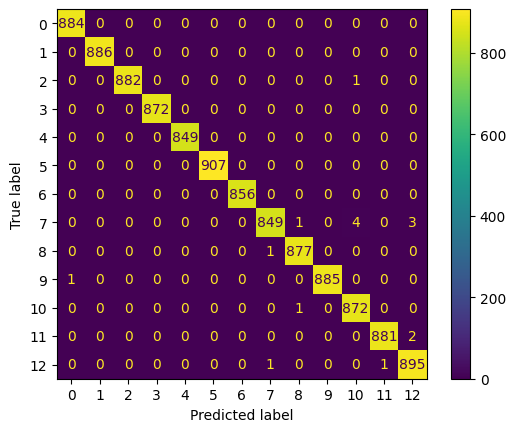

In [29]:
from sklearn import metrics

y_pred = modelsvc.predict(X_train)

cm = (confusion_matrix(y_train, y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
print(accuracy_score(y_train, y_pred))

0.9400940502964629


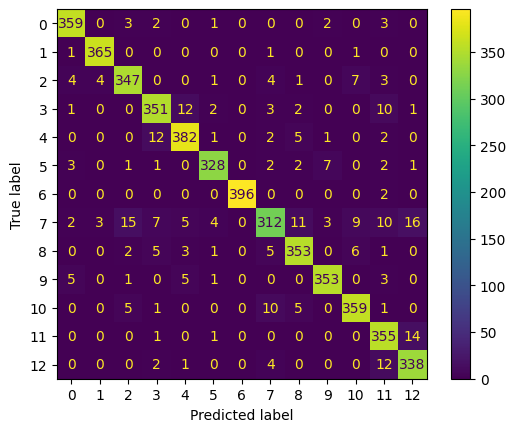

In [28]:
from sklearn import metrics

y_pred = modelsvc.predict(X_test)

cm = (confusion_matrix(y_test, y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
print(accuracy_score(y_test, y_pred))

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', C=0.1, solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

0.6073963719218298


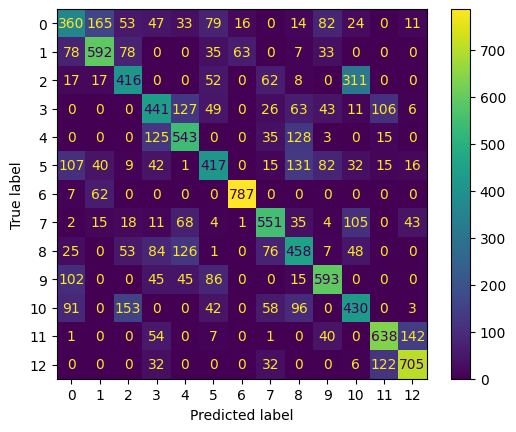

In [92]:
from sklearn import metrics

y_pred = model.predict(X_train)

cm = (confusion_matrix(y_train, y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
print(accuracy_score(y_train, y_pred))

0.6033530975260682


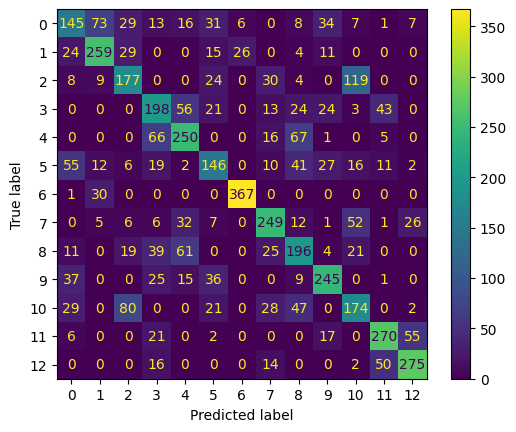

In [85]:
from sklearn import metrics

y_pred = model.predict(X_test)

cm = (confusion_matrix(y_test, y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
print(accuracy_score(y_test, y_pred))

In [41]:
model.coef_

array([[ 2.49744679e-03,  5.55821691e-04,  8.16198035e-02,
         2.88389456e-02,  1.46114250e-03,  2.22938811e-04,
         5.90624552e-01,  7.25122253e-01, -1.03242152e-01,
        -4.61563247e-02,  4.08436008e-02, -2.31621985e-02],
       [-1.54689173e-04,  1.99041204e-03, -1.14200190e-02,
         8.36069965e-02, -8.90305248e-05,  1.00995193e-03,
        -2.71535095e-01,  1.64188860e+00, -5.70440671e-02,
        -4.63951371e-02,  5.49400707e-01, -1.16480746e-01],
       [-2.49125397e-03,  1.58043645e-03,  1.79828226e-02,
         1.85876528e-01, -2.34667841e-03, -2.37432785e-04,
        -1.21819289e+00,  3.22594022e-01,  8.22325506e-02,
        -5.98844375e-02, -3.05879075e-01, -1.69042272e-02],
       [ 2.37358027e-03, -2.59877708e-03, -6.82818494e-02,
        -1.44966618e-01,  2.67046828e-03, -9.84814276e-04,
         8.10034324e-01, -1.27725542e+00,  2.60594924e-02,
         1.02536001e-01,  3.54458811e-01, -1.16529020e-02],
       [ 1.06232849e-03, -1.16731964e-03,  1.4788211

k-Nearest Neighbors

In [95]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

1.0


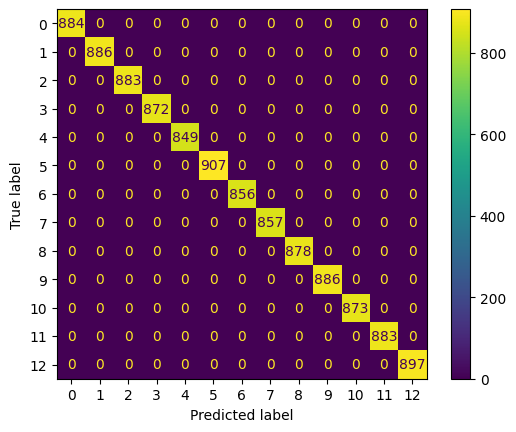

In [96]:
from sklearn import metrics

y_pred = knn_model.predict(X_train)

cm = (confusion_matrix(y_train, y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
print(accuracy_score(y_train, y_pred))

0.9278266203230423


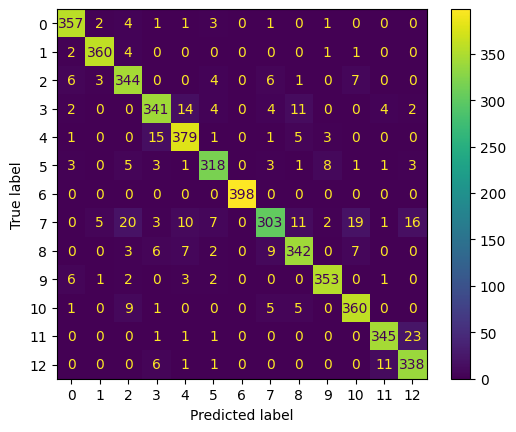

In [97]:
from sklearn import metrics

y_pred = knn_model.predict(X_test)

cm = (confusion_matrix(y_test, y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
print(accuracy_score(y_test, y_pred))